# Generate synthetic data

In [0]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima_process import arma_generate_sample
n = int(3000)
# alpha1 = 0.666, alpha2 = -.333
alphas = np.array([.1])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
# # AR(2)
# ar2 = arma_generate_sample(ar=ar, ma=ma, nsample=n) 
# plt.figure(figsize=(20,5))
# plt.plot( ar2)

T_1 =  arma_generate_sample(ar=ar, ma=ma, nsample=n).reshape(-1,1)
T_2 = arma_generate_sample(ar=ar, ma=ma, nsample=n).reshape(-1,1)
T_3 = arma_generate_sample(ar=ar, ma=ma, nsample=n).reshape(-1,1)
T_4 = arma_generate_sample(ar=ar, ma=ma, nsample=n).reshape(-1,1)
T_5 = arma_generate_sample(ar=ar, ma=ma, nsample=n).reshape(-1,1)
M =[[1 , 0 , 0 , 0 , 1],
[0 , 1 , 0 , 0 , 1],
[0 , 0 , 1 , 0 , 1],
[0 , 0 , 0 , 1 , 1],
[1 , -1 , 0 , 0 , 1]]
delta = np.zeros((n,1))
delta_anomal = np.zeros((n,1))
delta_anomal[300:320]   = np.ones((20,1))
delta_anomal[600:610]   = np.full((10,1),-0.7)
delta_anomal[1300:1320] = np.full((20,1),2)
delta_anomal[2100:2150] = np.full((50,1),-1.5)

# delta_anomal[41:50] = np.ones((9,1))
N = np.concatenate((T_1,T_2,T_3,T_4,delta), axis=1)
N_anomal =  np.concatenate((T_1,T_2,T_3,T_4,delta_anomal), axis=1)
B = N@M
B_anomal = N_anomal@M

T_1 = B[:,0]
T_2 = B[:,1]
T_3 = B[:,2]
T_4 = B[:,3]
T_5 = B[:,4]


T_1_anomal = B_anomal[:,0]
T_2_anomal = B_anomal[:,1]
T_3_anomal = B_anomal[:,2]
T_4_anomal = B_anomal[:,3]
T_5_anomal = B_anomal[:,4]

MD_T = np.concatenate((T_1.reshape((-1,1)),T_2.reshape((-1,1)),T_3.reshape((-1,1)),T_4.reshape((-1,1)),T_5.reshape((-1,1))),axis=1)
MD_T_anomaly = np.concatenate((T_1_anomal.reshape((-1,1)),T_2_anomal.reshape((-1,1)),T_3_anomal.reshape((-1,1)),T_4_anomal.reshape((-1,1)),T_5_anomal.reshape((-1,1))),axis=1)
MD_T.shape,MD_T_anomaly.shape

labels = np.zeros((n,1))
labels[300:320]     = 1
labels[600:610]     = 1
labels[1300:1320]   = 1
labels[2100:2150]   = 1
df_synthetic = pd.DataFrame(np.concatenate((MD_T_anomaly,labels), axis = 1))
df_synthetic.columns =  np.r_[np.array(['V'+str(i) for i in range(1,6)]),['is_anomaly']]
df_synthetic

,V1,V2,V3,V4,V5,is_anomaly
0,0.142487,-1.178184,1.569132,1.106891,1.640325,0.0
1,0.299361,-0.497105,-0.505582,0.064425,-0.638900,0.0
2,-0.134870,-0.050699,-1.590549,1.639128,-0.136990,0.0
3,0.118251,-0.181265,-0.682700,1.075405,0.329691,0.0
4,-0.438922,-1.048433,-1.953325,1.237037,-2.203643,0.0
...,...,...,...,...,...,...
2995,1.129619,-0.149452,-0.707156,-0.840981,-0.567969,0.0
2996,-0.234800,0.992676,-0.091148,0.520872,1.187599,0.0
2997,0.506162,-1.059046,0.438690,-2.586029,-2.700223,0.0
2998,1.122350,0.321395,-0.787998,-0.408501,0.247247,0.0


# OCSVM

In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from sklearn.svm import OneClassSVM
from sklearn import preprocessing
import sys

class OneClassSVM_AnomalyDetection_MV:

    @classmethod
    def from_DataFrame(cls,dataframe,window_width, dimension, nu, train_rate) -> 'OneClassSVM_AnomalyDetection_MV':
    	return cls(dataframe, dimension, window_width, nu, train_rate)

    @classmethod
    def from_file(cls, path, index_col, window_width, dimension, nu, train_rate) -> 'OneClassSVM_AnomalyDetection_MV':
    	df = read_csv(path, header=0, index_col=index_col, parse_dates=True,squeeze=True)
    	return cls(df, dimension, window_width, nu, train_rate)
     
    def __init__(self,dataframe, dimension, window_width, nu, train_rate):
        self.nu = nu
        self.df = dataframe
        self.window_width = window_width
        self.dimension = dimension
        self.window_width = window_width
		
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        self.X_origin = self.df.iloc[:,:dimension].values
        self.Y_origin = self.df.iloc[:,-1].values

        df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
        self.values = df_sensors
        self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

        self.train_size = int(len(self.values) * train_rate)

    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back),:self.dimension]
            dataX.append(a)
            dataY.append(dataset[i + look_back,:self.dimension].reshape(-1))
        return np.array(dataX), np.array(dataY)

    def build_sets(self):

        X = self.dataframe.iloc[:,:-1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

        self.validationsize = int(self.train_X.shape[0] * 0.1)
        self.val, self.test = self.test[:self.validationsize], self.test[self.validationsize:]
        self.val_X, self.val_y= self.test_X[:self.validationsize], self.test_y[:self.validationsize]
        self.test_X, self.test_y = self.test_X[self.validationsize:], self.test_y[self.validationsize:]
        
    def __build_sets(self):
	
        X = self.dataframe.iloc[:,:-1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

    def standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
#         print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        # self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()

    def compute_anomalyScores(self):
        self.errors = np.zeros_like(self.test[:,0])
        # compute anomalies
        warnings.filterwarnings("ignore")

        for i,_ in enumerate(self.test[:-self.window_width+1]):
            sys.stdout.write('\r'+str(i)+':'+str(len(self.test) - self.window_width))

            window = self.test[i:i+self.window_width]
            clf=OneClassSVM(nu=self.nu)
            clf.fit(window)
            error = clf.decision_function(window) 
            error[error>0] = 0
            self.errors[i:i+self.window_width] += error*-10


        # normalize anomaly score
        self.errors[:-self.window_width+1] /= self.window_width
        for i,error in enumerate(self.test[-self.window_width+1:]):
            self.errors[-self.window_width + 1 + i] /=self.window_width-(i+1)

        # self.errors_original = self.errors
        # scalar = preprocessing.MinMaxScaler((0,1)).fit(self.errors.reshape(-1,1))
        # self.errors = scalar.transform(self.errors.reshape(-1,1))*10


    def plot(self):
        fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(50,5))
        for i, ax in enumerate(axes.flatten()):
            data = self.df[self.df.columns[i]].iloc[:200]
            ax.plot(self.test_y[:,i], color='green',  linewidth=0.5,label='True Values')
            ax.plot(self.predictions[:,i], color='blue',  linewidth=0.5,label='Predictions')
            ax.plot(self.errors[:,i], color = 'red',  linewidth=0.5, label='Errors')
            ax.legend()
            
        plt.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)



# iforest = OneClassSVM_AnomalyDetection.from_file('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40903.csv',None,30,3,0.7,0.3)
# iforest.fit()
# auc = iforest.get_roc_auc(verbose=False,plot=True)


## Evaluation

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


1750:1750

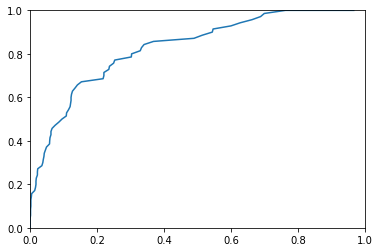

AUC:  0.7960068027210885
Time:  17


In [0]:
# dataframe,window_width, dimension, nu, train_rate

import datetime
startTime = datetime.datetime.now()
import glob
ocsvm = OneClassSVM_AnomalyDetection_MV.from_DataFrame(df_synthetic,350,5,0.9,0.3)
ocsvm.fit()
auc = ocsvm.get_roc_auc(verbose=False,plot=True)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.seconds)

# XGBoost Multivariate

In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from xgboost import XGBRegressor
from sklearn import preprocessing
import sys
from tensorflow import set_random_seed
set_random_seed(42)
from numpy.random import seed
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.layers import Conv1D,MaxPooling1D,Flatten
seed(42)
from keras import regularizers

def warn(*args, **kwargs):
    pass
    
class XGB_AnomalyDetection_ML:

    @classmethod
    def from_DataFrame(cls,dataframe,window_width, dimension, train_rate) -> 'XGB_AnomalyDetection_ML':
    	return cls(dataframe, window_width, dimension, train_rate)

    @classmethod
    def from_file(cls, path, index_col, window_width, dimension, train_rate) -> 'XGB_AnomalyDetection_ML':
    	df = read_csv(path, header=0, index_col=index_col, parse_dates=True,squeeze=True)
    	return cls(df, window_width, dimension, train_rate)
     
    def __init__(self,df, window_width, dimension, train_rate):

        self.dimension = dimension
        self.window_width = window_width


        self.df = df
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
        self.values = df_sensors
        self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

        # self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        # self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)  

    def reset_dataframe(self, df, dimension, train_rate):
        self.df = df
        self.dimension = dimension
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
        self.values = df_sensors
        self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]



        self.train_size = int(len(self.values) * train_rate)         

    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back),:self.dimension]
            dataX.append(a.reshape(-1))
            dataY.append(dataset[i + look_back,:self.dimension].reshape(-1))
        return numpy.array(dataX), numpy.array(dataY)
    
    def getWindowedVectors(self, X):
        vectors = np.zeros((len(X) - self.window_width+1,self.window_width))
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors[i] = X[i:i+self.window_width]
        return vectors

    def __build_sets(self):

        X = self.dataframe.iloc[:,:-1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

        self.validationsize = int(self.train_X.shape[0] * 0.1)
        self.val, self.test = self.test[:self.validationsize], self.test[self.validationsize:]
        self.val_X, self.val_y= self.test_X[:self.validationsize], self.test_y[:self.validationsize]
        self.test_X, self.test_y = self.test_X[self.validationsize:], self.test_y[self.validationsize:]

    def standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]




    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe.iloc[self.train_size:,:self.dimension], self.dataframe.iloc[self.train_size:,self.dimension:-1]))
        # print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()
        self.compute_Errors_RMSE()


    def plotTraining(self):
        history_dict = self.history.history
        loss_values = history_dict['loss'][1:]
        val_loss_values = history_dict['val_loss'][1:]
        self.n_epochs = range(2, self.n_epochs + 1)
        plt.plot(self.n_epochs, loss_values, 'bo', label='Training loss')
        plt.plot(self.n_epochs, val_loss_values, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def compute_anomalyScores(self):
        from sklearn.multioutput import MultiOutputRegressor

        # fitting
        multioutputregressor = MultiOutputRegressor(XGBRegressor(objective='reg:linear')).fit(self.train_X, self.train_y)

        # predicting
        self.predictions = multioutputregressor.predict(self.test_X) 
        # # self.train_X = numpy.reshape(self.train_X, (self.train_X.shape[0],self.dimension,self.train_X.shape[1]))
        # # self.test_X = numpy.reshape(self.test_X, (self.test_X.shape[0],self.dimension, self.test_X.shape[1]))

        # from keras.layers import Conv1D,MaxPooling1D,Flatten
        # self.model = Sequential()

        # self.model = Sequential()
        # self.model.add(LSTM(self.n_filters[0], batch_input_shape=(1, self.window_width, self.dimension), stateful=True, return_sequences=True))
        # self.model.add(LSTM(self.n_filters[1], batch_input_shape=(1, self.window_width, self.dimension), stateful=True))
        # self.model.add(Dense(self.dimension))
        # self.model.compile(optimizer='adam', loss='mse')
        # for i in range(self.n_epochs):
        #     sys.stdout.write('\r'+str(i)+':'+str(self.n_epochs))
        #     self.model.fit(self.train_X, self.train_y,validation_data=(self.val_X,self.val_y), epochs=1, batch_size=1, verbose=0, shuffle=False)
        #     self.model.reset_states()
        # print('')

        # # self.plotTraining()
        # self.predictions = self.model.predict(self.test_X, batch_size = 1)


    def compute_Errors_RMSE(self):

        rmse = sqrt(mean_squared_error(self.test_y.reshape(self.predictions.shape), self.predictions))
        self.errors = np.absolute(self.test_y.reshape(self.predictions.shape) - np.array(self.predictions))
        # print('Prediction Test RMS        E: %.3f' % rmse)       
   

    def plot(self):
        fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(50,5))
        for i, ax in enumerate(axes.flatten()):
            data = self.df[self.df.columns[i]].iloc[:200]
            ax.plot(self.test_y[:,i], color='green',  linewidth=0.5,label='True Values')
            ax.plot(self.predictions[:,i], color='blue',  linewidth=0.5,label='Predictions')
            ax.plot(self.errors[:,i], color = 'red',  linewidth=0.5, label='Errors')
            ax.legend()
            
        plt.show()

    def get_roc_auc(self, plot=True, verbose=True):
        self.euclidean_errors = numpy.linalg.norm(self.test_y.reshape(self.predictions.shape) - self.predictions, axis=1)
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size + self.validationsize
        true_anomaly_predicted_errors = self.euclidean_errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size - self.validationsize - self.window_width -1]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.euclidean_errors[self.euclidean_errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.euclidean_errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# filters = [[8,8,8,8], [4,4,4,4], [4,8,16,32], [16,32,48,64],  [32,64,12,24],[128,128,128,128],[64,64,64,64],[256,256,256,256],[128,256,512,1024]]
# kernelsizes = [2,3,4,6,8,16]
# dense = [18,36,72,144]



# xgb = XGB_ML_AnomalyDetection('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40903.csv',13,3,0.3)
# # xgb.reset_dataframe(df,5, 0.3)
# xgb.fit()
# # # cnn.plot()
# auc = xgb.get_roc_auc(verbose=False,plot=True)


# print(best_auc)

Using TensorFlow backend.


## Evaluation

[03:23:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:23:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:23:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:23:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:23:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


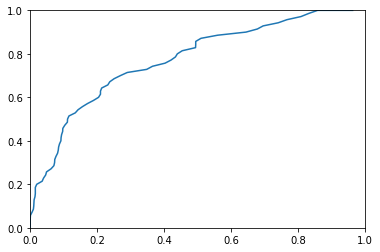

AUC:  0.7368649133293483
Time:  13


In [0]:
import datetime
startTime = datetime.datetime.now()
import glob
xgb = XGB_AnomalyDetection_ML.from_DataFrame(df_synthetic,108,5,0.3)
xgb.fit()
auc = xgb.get_roc_auc(verbose=False,plot=True)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.seconds)

# LOF

In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
import sys

class LOF_AnomalyDetection_MV:

    @classmethod
    def from_DataFrame(cls,dataframe,window_width, dimension, n_neighbors, train_rate) -> 'LOF_AnomalyDetection_MV':
    	return cls(dataframe, dimension, window_width, n_neighbors, train_rate)

    @classmethod
    def from_file(cls, path, index_col, window_width, dimension, n_neighbors, train_rate) -> 'LOF_AnomalyDetection_MV':
    	df = read_csv(path, header=0, index_col=index_col, parse_dates=True,squeeze=True)
    	return cls(df, dimension, window_width, n_neighbors, train_rate)
     
    def __init__(self,dataframe, dimension, window_width, n_neighbors, train_rate):
        self.n_neighbors = n_neighbors
        self.df = dataframe
        self.window_width = window_width
        self.dimension = dimension
        self.window_width = window_width
		
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        self.X_origin = self.df.iloc[:,:dimension].values
        self.Y_origin = self.df.iloc[:,-1].values

        df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
        self.values = df_sensors
        self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

        self.train_size = int(len(self.values) * train_rate)

    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back),:self.dimension]
            dataX.append(a)
            dataY.append(dataset[i + look_back,:self.dimension].reshape(-1))
        return np.array(dataX), np.array(dataY)

    def build_sets(self):

        X = self.dataframe.iloc[:,:-1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

        self.validationsize = int(self.train_X.shape[0] * 0.1)
        self.val, self.test = self.test[:self.validationsize], self.test[self.validationsize:]
        self.val_X, self.val_y= self.test_X[:self.validationsize], self.test_y[:self.validationsize]
        self.test_X, self.test_y = self.test_X[self.validationsize:], self.test_y[self.validationsize:]
        
    def __build_sets(self):
	
        X = self.dataframe.iloc[:,:-1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

    def standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
#         print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        # self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()

    def compute_anomalyScores(self):
        self.errors = np.zeros_like(self.test[:,0])
        # compute anomalies
        warnings.filterwarnings("ignore")

        for i,_ in enumerate(self.test[:-self.window_width+1]):
            sys.stdout.write('\r'+str(i)+':'+str(len(self.test) - self.window_width))

            window = self.test[i:i+self.window_width]
            clf=LocalOutlierFactor(self.n_neighbors,contamination ='auto')
            clf.fit_predict(window)
            error = clf.negative_outlier_factor_
            # error=error - 1 
            # error= error**(-1)
            self.errors[i:i+self.window_width] += 1/error


        # normalize anomaly score
        self.errors[:-self.window_width+1] /= self.window_width
        for i,error in enumerate(self.test[-self.window_width+1:]):
            self.errors[-self.window_width + 1 + i] /=self.window_width-(i+1)

        # self.errors_original = self.errors
        scalar = preprocessing.MinMaxScaler((0,1)).fit(self.errors.reshape(-1,1))
        self.errors = scalar.transform(self.errors.reshape(-1,1))*10


    def plot(self):
        fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(50,5))
        for i, ax in enumerate(axes.flatten()):
            data = self.df[self.df.columns[i]].iloc[:200]
            ax.plot(self.test_y[:,i], color='green',  linewidth=0.5,label='True Values')
            ax.plot(self.predictions[:,i], color='blue',  linewidth=0.5,label='Predictions')
            ax.plot(self.errors[:,i], color = 'red',  linewidth=0.5, label='Errors')
            ax.legend()
            
        plt.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        # true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, max(true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended),np.max(self.errors) + np.mean(self.errors))]

                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)



# iforest = OneClassSVM_AnomalyDetection.from_file('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40903.csv',None,30,3,0.7,0.3)
# iforest.fit()
# auc = iforest.get_roc_auc(verbose=False,plot=True)


## Evaluation

In [0]:
# dataframe,window_width, dimension, nu, train_rate

import datetime
startTime = datetime.datetime.now()
import glob

best_value, best_window, best_neighbor = 0,0,0
for i in range(1,30):
    window= np.random.randint(30,400)
    neighbors = np.random.randint(3,window/2)
    lof = LOF_AnomalyDetection_MV.from_DataFrame(df_synthetic,window,5,neighbors,0.3)
    lof.fit()
    auc = lof.get_roc_auc(verbose=False,plot=False)
    if auc > best_value:
        best_value = auc
        best_window = window
        best_neighbor = neighbors

    endTime = datetime.datetime.now()
    diff = endTime - startTime
    print('window:', window, ' - neighbors:', neighbors,' - Time: ',diff.seconds)

print('best: window: ', best_window,' - neighbor: ', best_neighbor, ' - auc:', best_value )

1777:1777AUC:  0.685734693877551
window: 323  - neighbors: 132  - Time:  18
1879:1879AUC:  0.6774727891156461
window: 221  - neighbors: 62  - Time:  25
1794:1794AUC:  0.6726734693877551
window: 306  - neighbors: 60  - Time:  37
2049:2049AUC:  0.4873877551020408
window: 51  - neighbors: 14  - Time:  39
1726:1726AUC:  0.6575510204081633
window: 374  - neighbors: 51  - Time:  52
2012:2012AUC:  0.5733197278911565
window: 88  - neighbors: 30  - Time:  55
1883:1883AUC:  0.6875680272108844
window: 217  - neighbors: 82  - Time:  63
1800:1800AUC:  0.6683571428571429
window: 300  - neighbors: 53  - Time:  74
1707:1707AUC:  0.6587823129251701
window: 393  - neighbors: 57  - Time:  89
1827:1827AUC:  0.6796054421768707
window: 273  - neighbors: 66  - Time:  99
1940:1940AUC:  0.6598809523809525
window: 160  - neighbors: 53  - Time:  104
1936:1936AUC:  0.5966938775510204
window: 164  - neighbors: 23  - Time:  109
1742:1742AUC:  0.6795238095238096
window: 358  - neighbors: 169  - Time:  132
1797:1797A

# DBSCAN

In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
import sys

class DBSCAN_AnomalyDetection_MV:

    @classmethod
    def from_DataFrame(cls,dataframe,window_width, dimension, eps, min_samples, train_rate,metric) -> 'DBSCAN_AnomalyDetection_MV':
    	return cls(dataframe, dimension, window_width, eps, min_samples, train_rate,metric)

    @classmethod
    def from_file(cls, path, index_col, window_width, dimension, eps, min_samples, train_rate,metric) -> 'DBSCAN_AnomalyDetection_MV':
    	df = read_csv(path, header=0, index_col=index_col, parse_dates=True,squeeze=True)
    	return cls(df, dimension, window_width, eps, min_samples, train_rate,metric)

    def __init__(self,dataframe, dimension, window_width, eps, min_samples, train_rate,metric):    
        self.df = dataframe
        self.eps = eps
        self.metric = metric
        self.min_samples = min_samples
        self.window_width = window_width
        self.dimension = dimension
        self.window_width = window_width
		
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        self.X_origin = self.df.iloc[:,:dimension].values
        self.Y_origin = self.df.iloc[:,-1].values

        df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
        self.values = df_sensors
        self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

        self.train_size = int(len(self.values) * train_rate)

    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back),:self.dimension]
            dataX.append(a)
            dataY.append(dataset[i + look_back,:self.dimension].reshape(-1))
        return np.array(dataX), np.array(dataY)

    def build_sets(self):

        X = self.dataframe.iloc[:,:-1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

        self.validationsize = int(self.train_X.shape[0] * 0.1)
        self.val, self.test = self.test[:self.validationsize], self.test[self.validationsize:]
        self.val_X, self.val_y= self.test_X[:self.validationsize], self.test_y[:self.validationsize]
        self.test_X, self.test_y = self.test_X[self.validationsize:], self.test_y[self.validationsize:]
        
    def __build_sets(self):
	
        X = self.dataframe.iloc[:,:-1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

    def standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
#         print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        # self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()

    def compute_anomalyScores(self):
        self.errors = np.zeros_like(self.test[:,0])
        # compute anomalies
        warnings.filterwarnings("ignore")

        for i,_ in enumerate(self.test[:-self.window_width+1]):
            sys.stdout.write('\r'+str(i)+':'+str(len(self.test) - self.window_width))

            window = self.test[i:i+self.window_width]
            clf=DBSCAN(self.eps, self.min_samples,metric = self.metric)
            error = clf.fit_predict(window)
            error[error>0] = 0
            error*=-1
            # error=error - 1 
            # error= error**(-1)
            self.errors[i:i+self.window_width] += error


        # normalize anomaly score
        self.errors[:-self.window_width+1] /= self.window_width
        for i,error in enumerate(self.test[-self.window_width+1:]):
            self.errors[-self.window_width + 1 + i] /=self.window_width-(i+1)

        # self.errors_original = self.errors
        # scalar = preprocessing.MinMaxScaler((0,1)).fit(self.errors.reshape(-1,1))
        # self.errors = scalar.transform(self.errors.reshape(-1,1))*10


    def plot(self):
        fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(50,5))
        for i, ax in enumerate(axes.flatten()):
            data = self.df[self.df.columns[i]].iloc[:200]
            ax.plot(self.test_y[:,i], color='green',  linewidth=0.5,label='True Values')
            ax.plot(self.predictions[:,i], color='blue',  linewidth=0.5,label='Predictions')
            ax.plot(self.errors[:,i], color = 'red',  linewidth=0.5, label='Errors')
            ax.legend()
            
        plt.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        # true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, max(true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended),np.max(self.errors) + np.mean(self.errors))]

                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)



# iforest = OneClassSVM_AnomalyDetection.from_file('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40903.csv',None,30,3,0.7,0.3)
# iforest.fit()
# auc = iforest.get_roc_auc(verbose=False,plot=True)


## Evaluation

2000:2000

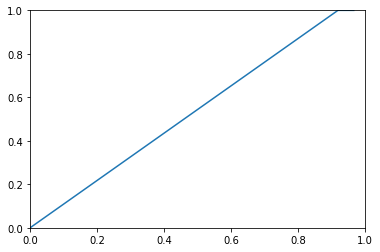

AUC:  0.506904761904762
Time:  3


In [0]:
import datetime
startTime = datetime.datetime.now()
import glob
dbscan = DBSCAN_AnomalyDetection_MV.from_DataFrame(df_synthetic,100,5,0.3,30, 0.3,'euclidean')
dbscan.fit()
auc = dbscan.get_roc_auc(verbose=False,plot=True)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.seconds)

# iForest

In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from sklearn.ensemble import IsolationForest 
from sklearn import preprocessing
import sys

class iForest_AnomalyDetection_MV:

    @classmethod
    def from_DataFrame(cls,dataframe,window_width, dimension, n_estimators, contamination, train_rate) -> 'iForest_AnomalyDetection_MV':
    	return cls(dataframe, dimension, window_width, n_estimators, contamination, train_rate)

    @classmethod
    def from_file(cls, path, index_col, window_width, dimension, n_estimators, contamination, train_rate) -> 'iForest_AnomalyDetection_MV':
    	df = read_csv(path, header=0, index_col=index_col, parse_dates=True,squeeze=True)
    	return cls(df, dimension, window_width, n_estimators, contamination, train_rate)

    def __init__(self,dataframe, dimension, window_width, n_estimators, contamination, train_rate):    
        self.df = dataframe
        self.n_estimators = n_estimators
        self.contamination = contamination
        self.window_width = window_width
        self.dimension = dimension
        self.window_width = window_width
		
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        self.X_origin = self.df.iloc[:,:dimension].values
        self.Y_origin = self.df.iloc[:,-1].values

        df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
        self.values = df_sensors
        self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

        self.train_size = int(len(self.values) * train_rate)

    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back),:self.dimension]
            dataX.append(a)
            dataY.append(dataset[i + look_back,:self.dimension].reshape(-1))
        return np.array(dataX), np.array(dataY)

    def build_sets(self):

        X = self.dataframe.iloc[:,:-1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

        self.validationsize = int(self.train_X.shape[0] * 0.1)
        self.val, self.test = self.test[:self.validationsize], self.test[self.validationsize:]
        self.val_X, self.val_y= self.test_X[:self.validationsize], self.test_y[:self.validationsize]
        self.test_X, self.test_y = self.test_X[self.validationsize:], self.test_y[self.validationsize:]
        
    def __build_sets(self):
	
        X = self.dataframe.iloc[:,:-1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

    def standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
#         print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        # self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()

    def compute_anomalyScores(self):
        self.errors = np.zeros_like(self.test[:,0])
        # compute anomalies
        warnings.filterwarnings("ignore")

        for i,_ in enumerate(self.test[:-self.window_width+1]):
            sys.stdout.write('\r'+str(i)+':'+str(len(self.test) - self.window_width))

            window = self.test[i:i+self.window_width]


            clf=IsolationForest(n_estimators=self.n_estimators,   # number of isolation trees
                            max_samples='auto', # number of samples to draw to create an isolation tree
                            contamination=self.contamination, # porportion of outliers
                            max_features=1.0,   #
                            bootstrap=False, 
                            n_jobs=-1, 
                            random_state=42, 
                            verbose=0, behaviour='new')
            clf.fit(window)
            error = clf.decision_function(window) 
            error[error>0] = 0
            self.errors[i:i+self.window_width] += error*-1

            # error=error - 1 
            # error= error**(-1)
            # self.errors[i:i+self.window_width] += error


        # normalize anomaly score
        self.errors[:-self.window_width+1] /= self.window_width
        for i,error in enumerate(self.test[-self.window_width+1:]):
            self.errors[-self.window_width + 1 + i] /=self.window_width-(i+1)

        # self.errors_original = self.errors
        # scalar = preprocessing.MinMaxScaler((0,1)).fit(self.errors.reshape(-1,1))
        # self.errors = scalar.transform(self.errors.reshape(-1,1))*10


    def plot(self):
        fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(50,5))
        for i, ax in enumerate(axes.flatten()):
            data = self.df[self.df.columns[i]].iloc[:200]
            ax.plot(self.test_y[:,i], color='green',  linewidth=0.5,label='True Values')
            ax.plot(self.predictions[:,i], color='blue',  linewidth=0.5,label='Predictions')
            ax.plot(self.errors[:,i], color = 'red',  linewidth=0.5, label='Errors')
            ax.legend()
            
        plt.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        # true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, max(true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended),np.max(self.errors) + np.mean(self.errors))]

                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)



# iforest = OneClassSVM_AnomalyDetection.from_file('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40903.csv',None,30,3,0.7,0.3)
# iforest.fit()
# auc = iforest.get_roc_auc(verbose=False,plot=True)


## Evaluation

2000:2000

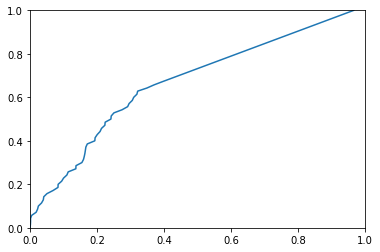

AUC:  0.6354353741496599
Time:  231


In [0]:
import datetime
startTime = datetime.datetime.now()
import glob
dbscan = iForest_AnomalyDetection_MV.from_DataFrame(df_synthetic,100,5,20, 'auto', 0.3)
dbscan.fit()
auc = dbscan.get_roc_auc(verbose=False,plot=True)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.seconds)